In [0]:

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import classification_report
from tensorflow.keras.layers import Dot,Bidirectional,Reshape,Permute,TimeDistributed,Dense,Layer,GRU,Concatenate,Attention,BatchNormalization ,Input, LSTM, Embedding, Dropout, Activation
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint,LearningRateScheduler
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import initializers, regularizers, constraints
from datetime import datetime
import nltk
import pandas as pd
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer 
from tqdm import tqdm
from nltk.corpus import stopwords
import warnings
import numpy as np
from sklearn.model_selection import train_test_split,cross_validate
from sklearn.tree import DecisionTreeClassifier
import os
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
from matplotlib import style
import random
from collections import Counter
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.svm import LinearSVC,SVC
from sklearn.linear_model import LogisticRegression,SGDClassifier
import string
!pip install python-dateutil
from dateutil import parser
warnings.filterwarnings('ignore')
style.use('ggplot')
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

stop_Words=set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [0]:
from google.colab import drive
drive.mount('/content/gdrive')
root_path = '/content/gdrive/My Drive/DRP'  #change dir to your project folder


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
os.chdir(root_path)
df_true=pd.read_csv('True.csv')

In [0]:
df_true

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"
...,...,...,...,...
21412,'Fully committed' NATO backs new U.S. approach...,BRUSSELS (Reuters) - NATO allies on Tuesday we...,worldnews,"August 22, 2017"
21413,LexisNexis withdrew two products from Chinese ...,"LONDON (Reuters) - LexisNexis, a provider of l...",worldnews,"August 22, 2017"
21414,Minsk cultural hub becomes haven from authorities,MINSK (Reuters) - In the shadow of disused Sov...,worldnews,"August 22, 2017"
21415,Vatican upbeat on possibility of Pope Francis ...,MOSCOW (Reuters) - Vatican Secretary of State ...,worldnews,"August 22, 2017"


In [0]:
df_fake=pd.read_csv('Fake.csv')

In [0]:
df_fake

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"
...,...,...,...,...
23476,McPain: John McCain Furious That Iran Treated ...,21st Century Wire says As 21WIRE reported earl...,Middle-east,"January 16, 2016"
23477,JUSTICE? Yahoo Settles E-mail Privacy Class-ac...,21st Century Wire says It s a familiar theme. ...,Middle-east,"January 16, 2016"
23478,Sunnistan: US and Allied ‘Safe Zone’ Plan to T...,Patrick Henningsen 21st Century WireRemember ...,Middle-east,"January 15, 2016"
23479,How to Blow $700 Million: Al Jazeera America F...,21st Century Wire says Al Jazeera America will...,Middle-east,"January 14, 2016"


###Intial visualisation of Complete Data

Text(0, 0.5, 'Count')

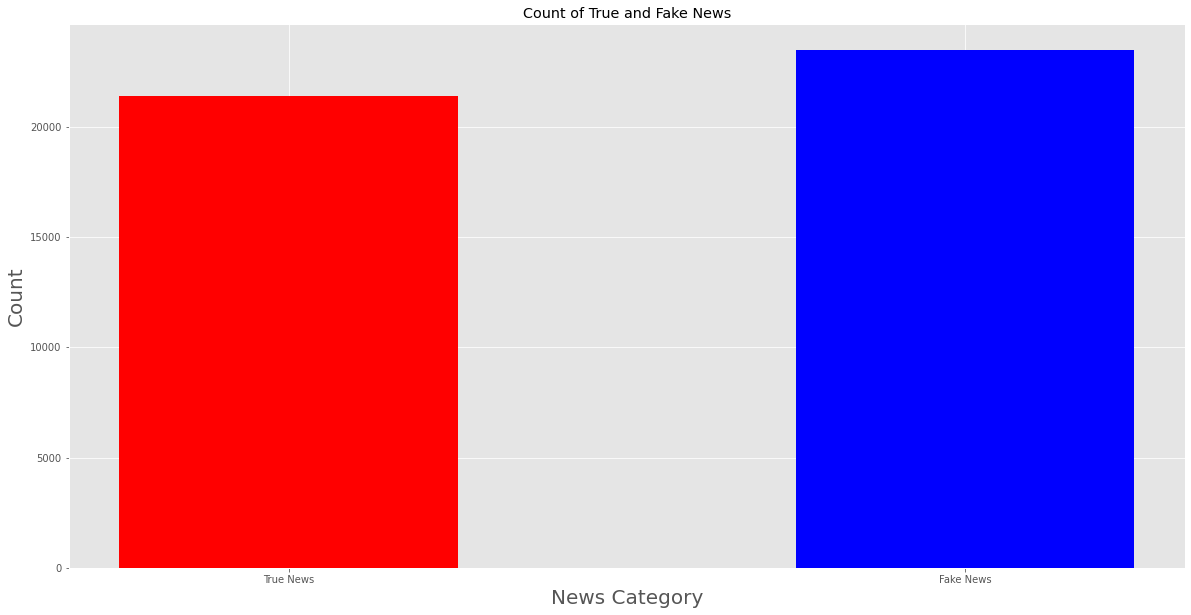

In [0]:
true_count,fake_count=len(df_true),len(df_fake)
fig=plt.figure(figsize=(20,10))
ax=fig.add_subplot(111)
ax.bar(['True News','Fake News'],[true_count,fake_count],color=['red','blue'],width=0.5)
ax.set_title('Count of True and Fake News')
ax.set_xlabel('News Category',fontsize=20)
ax.set_ylabel('Count',fontsize=20)

Text(0.5, 1.0, 'Count of Unique Subjects(Type of News) in True News Category')

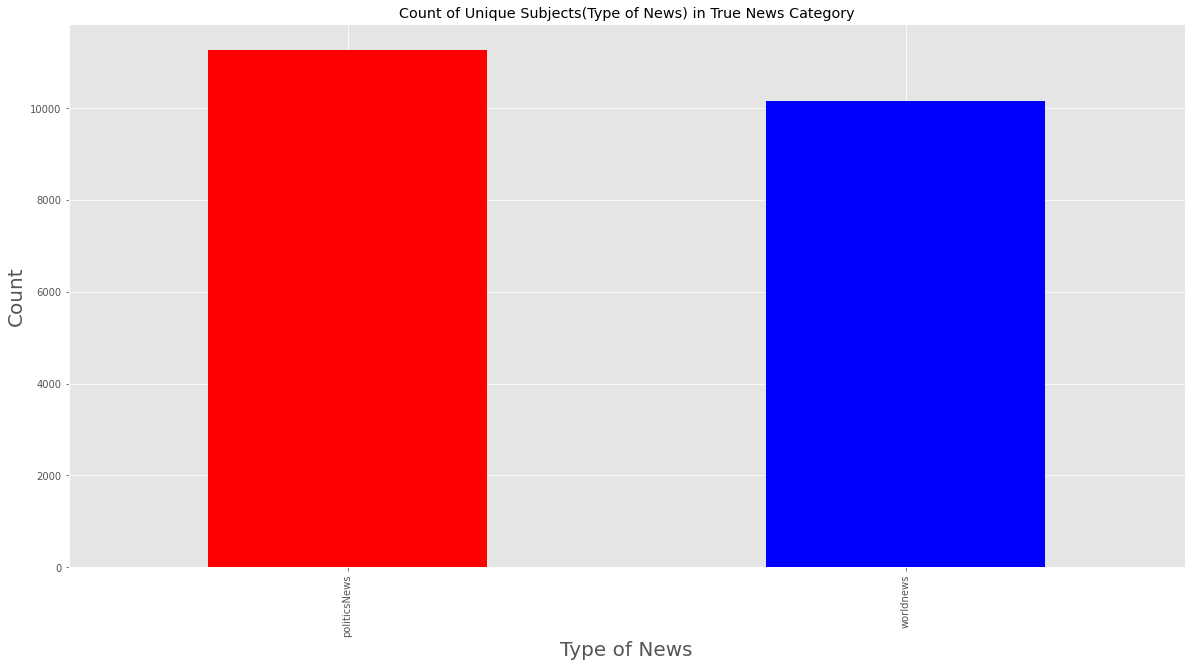

In [0]:
fig, ax = plt.subplots(figsize=(20, 10))
ax=df_true['subject'].value_counts().plot(kind='bar',ax=ax,color=['red','blue'])
ax.set_xlabel('Type of News',fontsize=20)
ax.set_ylabel('Count',fontsize=20)
ax.set_title('Count of Unique Subjects(Type of News) in True News Category')

Text(0.5, 1.0, 'Count of Unique Subjects(Type of News) in Fake News Category')

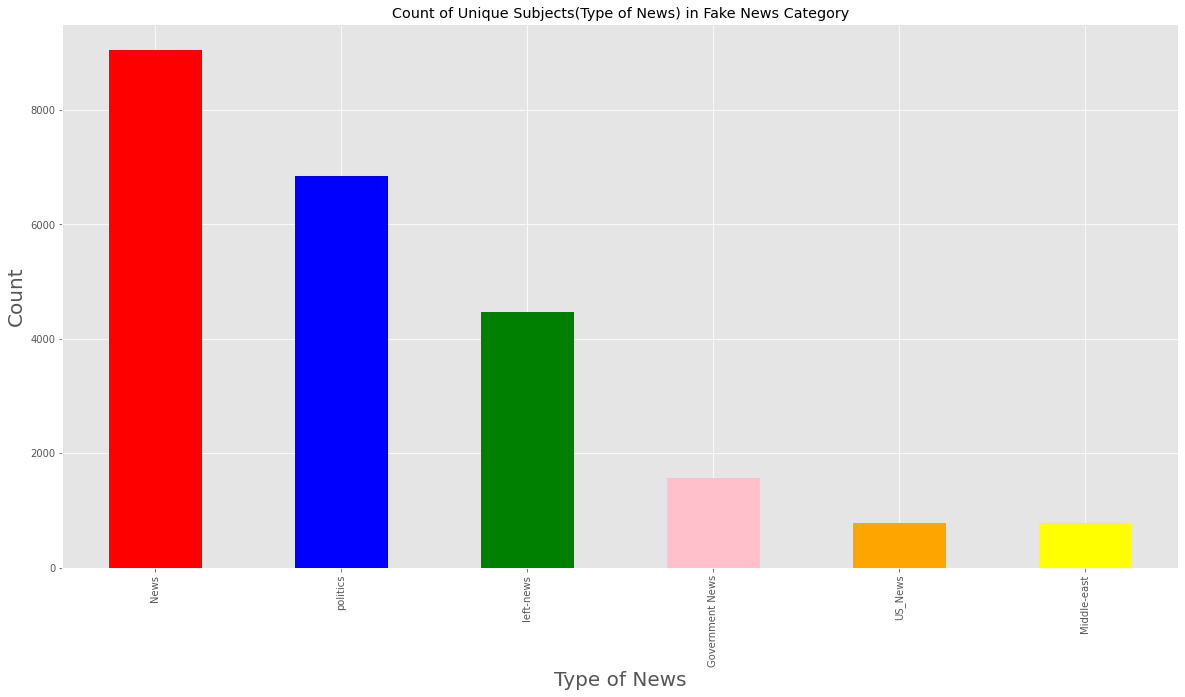

In [0]:
fig, ax = plt.subplots(figsize=(20, 10))
ax=df_fake['subject'].value_counts().plot(kind='bar',ax=ax,color=['red','blue','green','pink','orange','yellow'])
ax.set_xlabel('Type of News',fontsize=20)
ax.set_ylabel('Count',fontsize=20)
ax.set_title('Count of Unique Subjects(Type of News) in Fake News Category')

[('WASHINGTON', 6511), ('Reuters', 28363), ('The', 58563), ('head', 3321), ('conservative', 3779)]


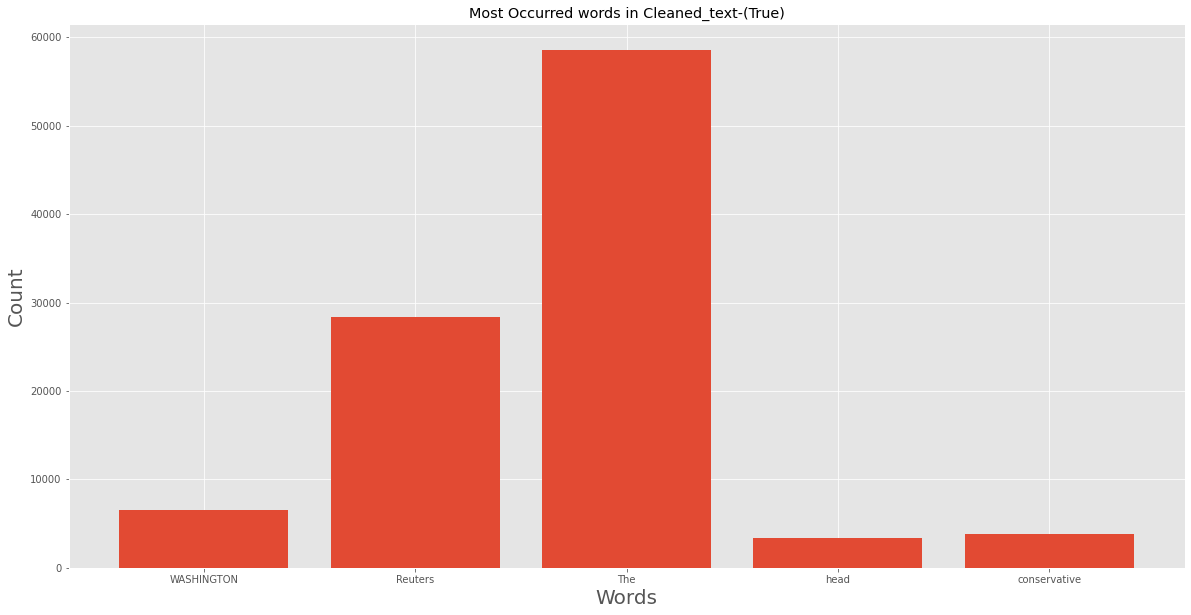

In [0]:
def unique_words_visulisation(text_series,title,label,n):
  result = list(Counter(" ".join(text_series.values.tolist()).split(" ")).items())[:n]
  print(result)
  fig, ax = plt.subplots(figsize=(20, 10))
  ax.bar([instance[0] for instance in result if instance[0]],[instance[1] for instance in result])
  ax.set_title('Most Occurred words in {}-({})'.format(title,label))
  ax.set_xlabel('Words',fontsize=20)
  ax.set_ylabel('Count',fontsize=20)
  plt.show()
  
unique_words_visulisation(df_true['Cleaned_text'],'Cleaned_text','True',5)

[('As', 64), ('U.S.', 3893), ('budget', 241), ('fight', 222), ('loom', 60)]


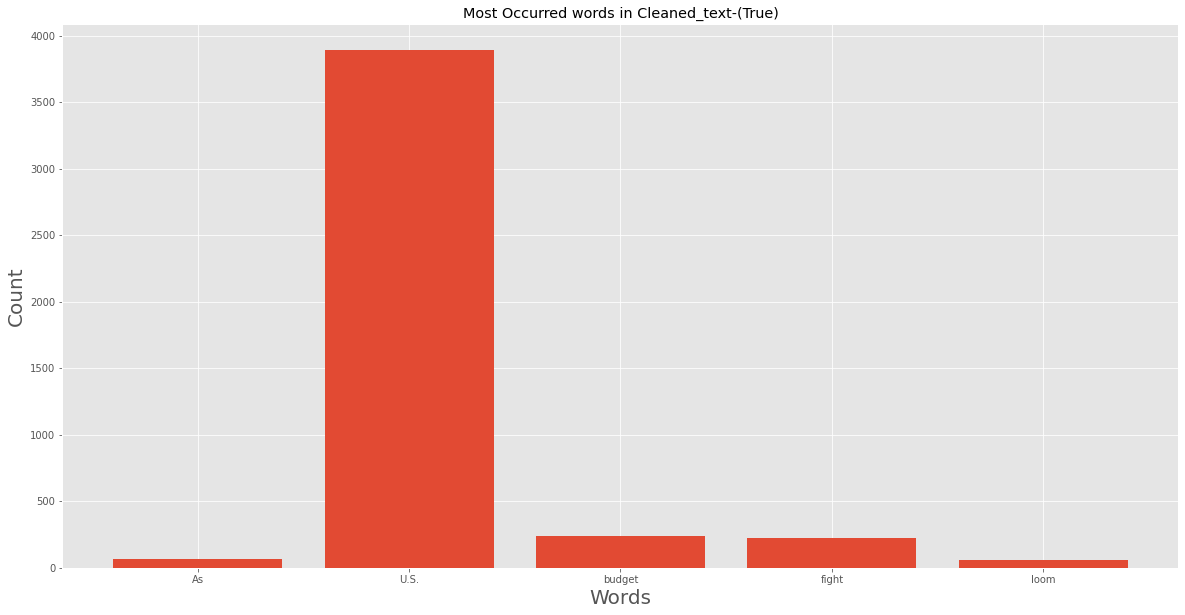

In [0]:
unique_words_visulisation(df_true['Cleaned_title'],'Cleaned_text','True',5)

[('Donald', 17180), ('Trump', 73353), ('wish', 745), ('Americans', 6110), ('Happy', 128)]


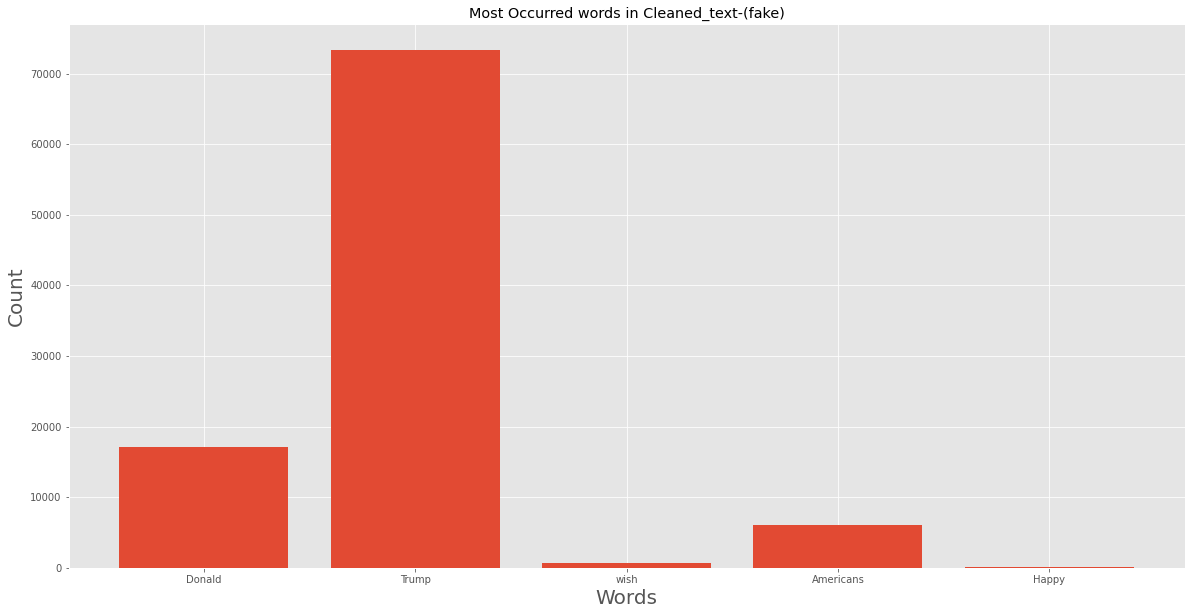

In [0]:
unique_words_visulisation(df_fake['Cleaned_text'],'Cleaned_text','fake',5)

[('Donald', 744), ('Trump', 7672), ('Sends', 43), ('Out', 803), ('Embarrassing', 50)]


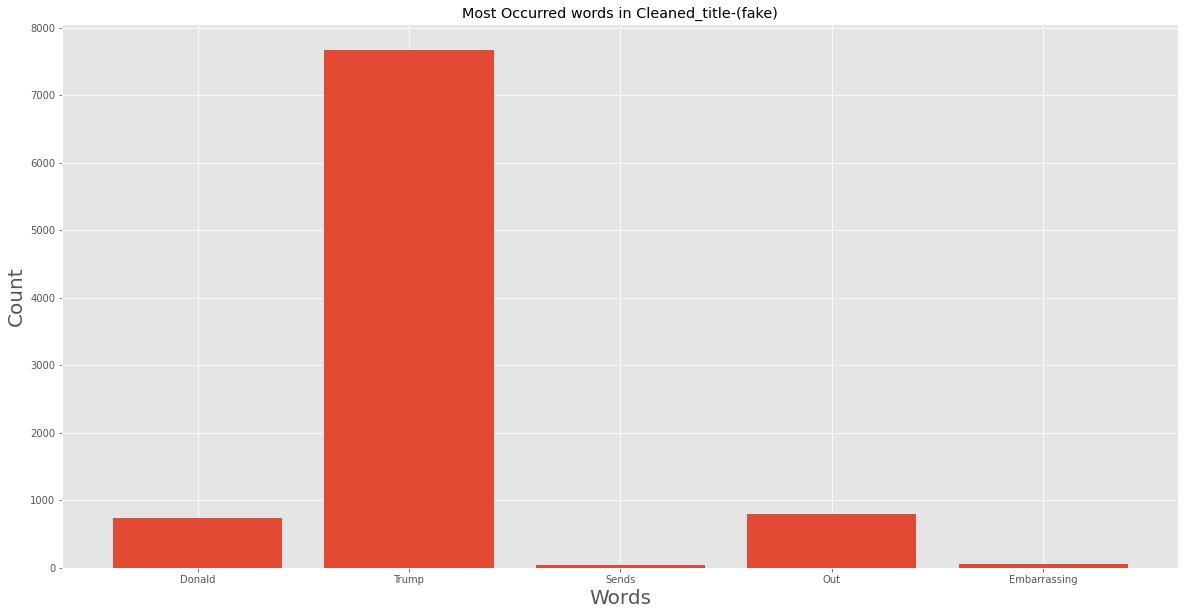

In [0]:
unique_words_visulisation(df_fake['Cleaned_title'],'Cleaned_title','fake',5)

## Replication of the Orginal Paper

### Preprocessing the Data

In [0]:
def cleaning_pipeline(sentence):
  punctuation_set = set(string.punctuation)
  lemmatizer = WordNetLemmatizer()

  tokens=word_tokenize(sentence)##Word Tokens

  tokens = [word for word in tokens if word not in punctuation_set]    ## Removing Punctuation
  tokens=[word for word in tokens if word not in stop_Words]##Removing Stop Words

  tokens=[word for word in tokens if not word.isdigit()]## Removing Alphanumeric values
  
  tokens=[lemmatizer.lemmatize(word) for word in tokens]## Stemming/Lemmatizing

  sentence_cleaned=' '.join(tokens)

  return sentence_cleaned

### Filtering of the Data

In [0]:
for instance in df_fake['date'].values:
  if len(instance)>17:
    df_fake=df_fake.drop(df_fake[df_fake['date']==instance].index)

    
def to_Datetime(instance):
    return parser.parse(instance)
df_true['date']=df_true['date'].str.replace(',', '')

df_fake['date']=df_fake['date'].str.replace(',', '')
df_true['new_date']=df_true['date'].map(to_Datetime)
df_fake['new_date']=df_fake['date'].map(to_Datetime)

In [0]:
mask_fake=(df_fake['new_date'].dt.year==2016)
mask_true=(df_true['new_date'].dt.year==2016)
exp_fake=df_fake[mask_fake &(df_fake['subject']=='politics')&(df_fake['text'].str.len()>=200)]
exp_true=df_true[mask_true & (df_true['subject']=='politicsNews')&(df_true['text'].str.len()>=200)]


In [0]:
exp_true['Cleaned_text']=exp_true['text'].map(cleaning_pipeline)
exp_fake['Cleaned_text']=exp_fake['text'].map(cleaning_pipeline)


exp_true_array=exp_true['Cleaned_text'].to_numpy().reshape(-1,)
exp_fake_array=exp_fake['Cleaned_text'].to_numpy().reshape(-1,)
exp_labels_true=np.ones(len(exp_true_array),dtype=int)
exp_labels_fake=np.zeros(len(exp_fake_array),dtype=int)

X_raw_exp=np.array(np.concatenate([exp_true_array,exp_fake_array]))
y_exp=np.array(np.concatenate([exp_labels_true,exp_labels_fake]))

Zipped=list(zip(X_raw_exp, y_exp))##Randomly suffling the X and y to avoid biasness
random.shuffle(Zipped)
X_raw_exp, y_exp = zip(*Zipped)

X_raw_exp=np.array(X_raw_exp)
y_exp=np.array(y_exp)


### Feature Extraction(TD-IDF) and Testing Different Machine Learning Algorithms

In [0]:
def gridsearchcv(model,model_name,tf=False):
  ngram_ranges={'Unigram ':(1,1),'Bigram':(2,2),'TriGram':(3,3),'FourGram':(4,4)}
  max_features_ranges=[1000,5000,10000,50000]
  types=['TFIDF','TF']

  final_dic={}
  for max_features in tqdm(max_features_ranges):
    for ngram_range in list(ngram_ranges.values()):
        if tf:
          tfs=CountVectorizer(max_features=max_features,ngram_range=ngram_range)
          X_tdidf=tfs.fit_transform(X_raw_exp)
          i=1
          
        else:
          tdidf=TfidfVectorizer(max_features=max_features,ngram_range=ngram_range)###Optimize these parameter and note the results
          X_tdidf=tdidf.fit_transform(X_raw_exp)
          i=0
        clf=model()
        X_train,X_test,y_train,y_test=train_test_split(X_tdidf,y_exp,test_size=0.2)
        clf.fit(X_train,y_train)
        y_predict=clf.predict(X_test)
        score=accuracy_score(y_test,y_predict)
        reverse_dic={v:k for k,v in ngram_ranges.items()}
    
        final_dic[model_name+'-'+reverse_dic[ngram_range]+'-'+str(max_features)+'-'+types[i]]=score
  print(final_dic)
gridsearchcv(LogisticRegression,'LogisticRegression')## do this for each model and tF ##rREHAN SEE THE BELOW output

100%|██████████| 4/4 [01:56<00:00, 29.15s/it]

{'LogisticRegression-Unigram -1000-TFIDF': 0.9634235552304315, 'LogisticRegression-Bigram-1000-TFIDF': 0.9407461594732992, 'LogisticRegression-TriGram-1000-TFIDF': 0.9275786393562546, 'LogisticRegression-FourGram-1000-TFIDF': 0.8178493050475494, 'LogisticRegression-Unigram -5000-TFIDF': 0.9561082662765179, 'LogisticRegression-Bigram-5000-TFIDF': 0.9487929773226043, 'LogisticRegression-TriGram-5000-TFIDF': 0.922457937088515, 'LogisticRegression-FourGram-5000-TFIDF': 0.8910021945866862, 'LogisticRegression-Unigram -10000-TFIDF': 0.9517190929041697, 'LogisticRegression-Bigram-10000-TFIDF': 0.9597659107534747, 'LogisticRegression-TriGram-10000-TFIDF': 0.9158741770299926, 'LogisticRegression-FourGram-10000-TFIDF': 0.8917337234820776, 'LogisticRegression-Unigram -50000-TFIDF': 0.9626920263350403, 'LogisticRegression-Bigram-50000-TFIDF': 0.9370885149963424, 'LogisticRegression-TriGram-50000-TFIDF': 0.8771031455742502, 'LogisticRegression-FourGram-50000-TFIDF': 0.7542062911485004}


In [0]:
gridsearchcv(LinearSVC,'LinearSVC')## do this for each model and tf

100%|██████████| 4/4 [01:53<00:00, 28.46s/it]

{'LinearSVC-Unigram -1000-TFIDF': 0.9875640087783467, 'LinearSVC-Bigram-1000-TFIDF': 0.950256035113387, 'LinearSVC-TriGram-1000-TFIDF': 0.8997805413313826, 'LinearSVC-FourGram-1000-TFIDF': 0.8405267008046818, 'LinearSVC-Unigram -5000-TFIDF': 0.9795171909290417, 'LinearSVC-Bigram-5000-TFIDF': 0.9707388441843453, 'LinearSVC-TriGram-5000-TFIDF': 0.9458668617410387, 'LinearSVC-FourGram-5000-TFIDF': 0.8873445501097293, 'LinearSVC-Unigram -10000-TFIDF': 0.9787856620336504, 'LinearSVC-Bigram-10000-TFIDF': 0.972201901975128, 'LinearSVC-TriGram-10000-TFIDF': 0.936356986100951, 'LinearSVC-FourGram-10000-TFIDF': 0.9005120702267739, 'LinearSVC-Unigram -50000-TFIDF': 0.9729334308705194, 'LinearSVC-Bigram-50000-TFIDF': 0.9700073152889539, 'LinearSVC-TriGram-50000-TFIDF': 0.9509875640087784, 'LinearSVC-FourGram-50000-TFIDF': 0.9217264081931237}


In [0]:
gridsearchcv(SGDClassifier,'SGDClassifier')## do this for each model and tF

100%|██████████| 4/4 [01:54<00:00, 28.58s/it]

{'SGDClassifier-Unigram -1000-TFIDF': 0.9817117776152158, 'SGDClassifier-Bigram-1000-TFIDF': 0.9561082662765179, 'SGDClassifier-TriGram-1000-TFIDF': 0.9253840526700805, 'SGDClassifier-FourGram-1000-TFIDF': 0.8295537673738113, 'SGDClassifier-Unigram -5000-TFIDF': 0.9787856620336504, 'SGDClassifier-Bigram-5000-TFIDF': 0.9612289685442575, 'SGDClassifier-TriGram-5000-TFIDF': 0.9407461594732992, 'SGDClassifier-FourGram-5000-TFIDF': 0.8814923189465984, 'SGDClassifier-Unigram -10000-TFIDF': 0.9802487198244331, 'SGDClassifier-Bigram-10000-TFIDF': 0.9729334308705194, 'SGDClassifier-TriGram-10000-TFIDF': 0.9334308705193856, 'SGDClassifier-FourGram-10000-TFIDF': 0.8705193855157278, 'SGDClassifier-Unigram -50000-TFIDF': 0.9787856620336504, 'SGDClassifier-Bigram-50000-TFIDF': 0.9817117776152158, 'SGDClassifier-TriGram-50000-TFIDF': 0.9458668617410387, 'SGDClassifier-FourGram-50000-TFIDF': 0.9049012435991222}


In [0]:
gridsearchcv(KNeighborsClassifier,'KNeighborsClassifier')## do this for each model and tF

100%|██████████| 4/4 [01:59<00:00, 29.89s/it]

{'KNeighborsClassifier-Unigram -1000-TFIDF': 0.8522311631309437, 'KNeighborsClassifier-Bigram-1000-TFIDF': 0.49012435991221653, 'KNeighborsClassifier-TriGram-1000-TFIDF': 0.6554498902706657, 'KNeighborsClassifier-FourGram-1000-TFIDF': 0.7410387710314558, 'KNeighborsClassifier-Unigram -5000-TFIDF': 0.8361375274323336, 'KNeighborsClassifier-Bigram-5000-TFIDF': 0.36137527432333577, 'KNeighborsClassifier-TriGram-5000-TFIDF': 0.40087783467446964, 'KNeighborsClassifier-FourGram-5000-TFIDF': 0.5610826627651793, 'KNeighborsClassifier-Unigram -10000-TFIDF': 0.8193123628383321, 'KNeighborsClassifier-Bigram-10000-TFIDF': 0.8302852962692027, 'KNeighborsClassifier-TriGram-10000-TFIDF': 0.3496708119970739, 'KNeighborsClassifier-FourGram-10000-TFIDF': 0.4228237015362107, 'KNeighborsClassifier-Unigram -50000-TFIDF': 0.8354059985369422, 'KNeighborsClassifier-Bigram-50000-TFIDF': 0.888807607900512, 'KNeighborsClassifier-TriGram-50000-TFIDF': 0.3196781272860278, 'KNeighborsClassifier-FourGram-50000-TFIDF

In [0]:
gridsearchcv(DecisionTreeClassifier,'DecisionTreeClassifier')## do this for each model and tF

100%|██████████| 4/4 [02:10<00:00, 32.73s/it]

{'DecisionTreeClassifier-Unigram -1000-TFIDF': 0.986100950987564, 'DecisionTreeClassifier-Bigram-1000-TFIDF': 0.8968544257498171, 'DecisionTreeClassifier-TriGram-1000-TFIDF': 0.8858814923189466, 'DecisionTreeClassifier-FourGram-1000-TFIDF': 0.8302852962692027, 'DecisionTreeClassifier-Unigram -5000-TFIDF': 0.9912216532553035, 'DecisionTreeClassifier-Bigram-5000-TFIDF': 0.908558888076079, 'DecisionTreeClassifier-TriGram-5000-TFIDF': 0.8917337234820776, 'DecisionTreeClassifier-FourGram-5000-TFIDF': 0.8551572787125091, 'DecisionTreeClassifier-Unigram -10000-TFIDF': 0.9890270665691295, 'DecisionTreeClassifier-Bigram-10000-TFIDF': 0.8990490124359912, 'DecisionTreeClassifier-TriGram-10000-TFIDF': 0.8961228968544257, 'DecisionTreeClassifier-FourGram-10000-TFIDF': 0.8471104608632041, 'DecisionTreeClassifier-Unigram -50000-TFIDF': 0.9897585954645208, 'DecisionTreeClassifier-Bigram-50000-TFIDF': 0.9261155815654718, 'DecisionTreeClassifier-TriGram-50000-TFIDF': 0.8924652523774689, 'DecisionTreeCla

In [0]:
gridsearchcv(DecisionTreeClassifier,'DecisionTreeClassifier')## do this for each model and tF

100%|██████████| 4/4 [02:10<00:00, 32.63s/it]

{'DecisionTreeClassifier-Unigram -1000-TFIDF': 0.9934162399414777, 'DecisionTreeClassifier-Bigram-1000-TFIDF': 0.9005120702267739, 'DecisionTreeClassifier-TriGram-1000-TFIDF': 0.888807607900512, 'DecisionTreeClassifier-FourGram-1000-TFIDF': 0.825164594001463, 'DecisionTreeClassifier-Unigram -5000-TFIDF': 0.9912216532553035, 'DecisionTreeClassifier-Bigram-5000-TFIDF': 0.894659839063643, 'DecisionTreeClassifier-TriGram-5000-TFIDF': 0.8917337234820776, 'DecisionTreeClassifier-FourGram-5000-TFIDF': 0.852962692026335, 'DecisionTreeClassifier-Unigram -10000-TFIDF': 0.9912216532553035, 'DecisionTreeClassifier-Bigram-10000-TFIDF': 0.9107534747622531, 'DecisionTreeClassifier-TriGram-10000-TFIDF': 0.8931967812728603, 'DecisionTreeClassifier-FourGram-10000-TFIDF': 0.8288222384784198, 'DecisionTreeClassifier-Unigram -50000-TFIDF': 0.9839063643013899, 'DecisionTreeClassifier-Bigram-50000-TFIDF': 0.9034381858083395, 'DecisionTreeClassifier-TriGram-50000-TFIDF': 0.8895391367959035, 'DecisionTreeClass

In [0]:
gridsearchcv(LogisticRegression,'LogisticRegression',tf=True)## do this for each model and tF

100%|██████████| 4/4 [01:59<00:00, 29.95s/it]

{'LogisticRegression-Unigram -1000-TF': 0.9897585954645208, 'LogisticRegression-Bigram-1000-TF': 0.9634235552304315, 'LogisticRegression-TriGram-1000-TF': 0.9158741770299926, 'LogisticRegression-FourGram-1000-TF': 0.831016825164594, 'LogisticRegression-Unigram -5000-TF': 0.9875640087783467, 'LogisticRegression-Bigram-5000-TF': 0.9634235552304315, 'LogisticRegression-TriGram-5000-TF': 0.9414776883686906, 'LogisticRegression-FourGram-5000-TF': 0.8697878566203365, 'LogisticRegression-Unigram -10000-TF': 0.9890270665691295, 'LogisticRegression-Bigram-10000-TF': 0.9692757863935626, 'LogisticRegression-TriGram-10000-TF': 0.9297732260424286, 'LogisticRegression-FourGram-10000-TF': 0.8975859546452085, 'LogisticRegression-Unigram -50000-TF': 0.9868324798829554, 'LogisticRegression-Bigram-50000-TF': 0.9758595464520848, 'LogisticRegression-TriGram-50000-TF': 0.9370885149963424, 'LogisticRegression-FourGram-50000-TF': 0.8997805413313826}


In [0]:
gridsearchcv(LinearSVC,'LinearSVC',tf=True)## do this for each model and tf

100%|██████████| 4/4 [01:56<00:00, 29.17s/it]

{'LinearSVC-Unigram -1000-TF': 0.9890270665691295, 'LinearSVC-Bigram-1000-TF': 0.9370885149963424, 'LinearSVC-TriGram-1000-TF': 0.9063643013899049, 'LinearSVC-FourGram-1000-TF': 0.8383321141185077, 'LinearSVC-Unigram -5000-TF': 0.9897585954645208, 'LinearSVC-Bigram-5000-TF': 0.964155084125823, 'LinearSVC-TriGram-5000-TF': 0.9158741770299926, 'LinearSVC-FourGram-5000-TF': 0.866861741038771, 'LinearSVC-Unigram -10000-TF': 0.9926847110460864, 'LinearSVC-Bigram-10000-TF': 0.9765910753474762, 'LinearSVC-TriGram-10000-TF': 0.9268471104608632, 'LinearSVC-FourGram-10000-TF': 0.8873445501097293, 'LinearSVC-Unigram -50000-TF': 0.9897585954645208, 'LinearSVC-Bigram-50000-TF': 0.9700073152889539, 'LinearSVC-TriGram-50000-TF': 0.93050475493782, 'LinearSVC-FourGram-50000-TF': 0.880760790051207}


In [0]:
gridsearchcv(SGDClassifier,'SGDClassifier',tf=True)## do this for each model and tF

100%|██████████| 4/4 [01:55<00:00, 28.75s/it]

{'SGDClassifier-Unigram -1000-TF': 0.9802487198244331, 'SGDClassifier-Bigram-1000-TF': 0.9392831016825165, 'SGDClassifier-TriGram-1000-TF': 0.8961228968544257, 'SGDClassifier-FourGram-1000-TF': 0.839063643013899, 'SGDClassifier-Unigram -5000-TF': 0.9765910753474762, 'SGDClassifier-Bigram-5000-TF': 0.9473299195318216, 'SGDClassifier-TriGram-5000-TF': 0.9326993416239941, 'SGDClassifier-FourGram-5000-TF': 0.8705193855157278, 'SGDClassifier-Unigram -10000-TF': 0.9787856620336504, 'SGDClassifier-Bigram-10000-TF': 0.9648866130212144, 'SGDClassifier-TriGram-10000-TF': 0.9356254572055597, 'SGDClassifier-FourGram-10000-TF': 0.8800292611558157, 'SGDClassifier-Unigram -50000-TF': 0.9809802487198245, 'SGDClassifier-Bigram-50000-TF': 0.9656181419166057, 'SGDClassifier-TriGram-50000-TF': 0.944403803950256, 'SGDClassifier-FourGram-50000-TF': 0.8785662033650329}


In [0]:
gridsearchcv(KNeighborsClassifier,'KNeighborsClassifier',tf=True)## do this for each model and tF

100%|██████████| 4/4 [01:59<00:00, 29.82s/it]

{'KNeighborsClassifier-Unigram -1000-TF': 0.8836869056327725, 'KNeighborsClassifier-Bigram-1000-TF': 0.7629846378931968, 'KNeighborsClassifier-TriGram-1000-TF': 0.811265544989027, 'KNeighborsClassifier-FourGram-1000-TF': 0.648134601316752, 'KNeighborsClassifier-Unigram -5000-TF': 0.8902706656912948, 'KNeighborsClassifier-Bigram-5000-TF': 0.6561814191660571, 'KNeighborsClassifier-TriGram-5000-TF': 0.6869056327724945, 'KNeighborsClassifier-FourGram-5000-TF': 0.7073884418434528, 'KNeighborsClassifier-Unigram -10000-TF': 0.8749085588880761, 'KNeighborsClassifier-Bigram-10000-TF': 0.6115581565471836, 'KNeighborsClassifier-TriGram-10000-TF': 0.5954645208485735, 'KNeighborsClassifier-FourGram-10000-TF': 0.6459400146305779, 'KNeighborsClassifier-Unigram -50000-TF': 0.8595464520848574, 'KNeighborsClassifier-Bigram-50000-TF': 0.46232626188734455, 'KNeighborsClassifier-TriGram-50000-TF': 0.3789319678127286, 'KNeighborsClassifier-FourGram-50000-TF': 0.4996342355523043}


In [0]:
gridsearchcv(DecisionTreeClassifier,'DecisionTreeClassifier',tf=True)## do this for each model and tF

100%|██████████| 4/4 [02:06<00:00, 31.71s/it]

{'DecisionTreeClassifier-Unigram -1000-TF': 0.9897585954645208, 'DecisionTreeClassifier-Bigram-1000-TF': 0.8983174835405998, 'DecisionTreeClassifier-TriGram-1000-TF': 0.8697878566203365, 'DecisionTreeClassifier-FourGram-1000-TF': 0.7951719092904169, 'DecisionTreeClassifier-Unigram -5000-TF': 0.9853694220921726, 'DecisionTreeClassifier-Bigram-5000-TF': 0.9173372348207754, 'DecisionTreeClassifier-TriGram-5000-TF': 0.8866130212143379, 'DecisionTreeClassifier-FourGram-5000-TF': 0.8185808339429408, 'DecisionTreeClassifier-Unigram -10000-TF': 0.9890270665691295, 'DecisionTreeClassifier-Bigram-10000-TF': 0.9180687637161667, 'DecisionTreeClassifier-TriGram-10000-TF': 0.880760790051207, 'DecisionTreeClassifier-FourGram-10000-TF': 0.8098024871982443, 'DecisionTreeClassifier-Unigram -50000-TF': 0.9882955376737381, 'DecisionTreeClassifier-Bigram-50000-TF': 0.9173372348207754, 'DecisionTreeClassifier-TriGram-50000-TF': 0.8727139722019019, 'DecisionTreeClassifier-FourGram-50000-TF': 0.81419166057059

In [0]:
gridsearchcv(SVC,'SVC',tf=False)## do this for each model and tF

100%|██████████| 4/4 [05:09<00:00, 77.26s/it]

{'SVC-Unigram -1000-TFIDF': 0.9729334308705194, 'SVC-Bigram-1000-TFIDF': 0.9473299195318216, 'SVC-TriGram-1000-TFIDF': 0.908558888076079, 'SVC-FourGram-1000-TFIDF': 0.8295537673738113, 'SVC-Unigram -5000-TFIDF': 0.9743964886613021, 'SVC-Bigram-5000-TFIDF': 0.9575713240673006, 'SVC-TriGram-5000-TFIDF': 0.9173372348207754, 'SVC-FourGram-5000-TFIDF': 0.8778346744696416, 'SVC-Unigram -10000-TFIDF': 0.9700073152889539, 'SVC-Bigram-10000-TFIDF': 0.9656181419166057, 'SVC-TriGram-10000-TFIDF': 0.9136795903438186, 'SVC-FourGram-10000-TFIDF': 0.8741770299926848, 'SVC-Unigram -50000-TFIDF': 0.972201901975128, 'SVC-Bigram-50000-TFIDF': 0.9531821506949525, 'SVC-TriGram-50000-TFIDF': 0.8873445501097293, 'SVC-FourGram-50000-TFIDF': 0.8134601316752011}


In [0]:
gridsearchcv(SVC,'SVC',tf=True)## do this for each model and tF

100%|██████████| 4/4 [04:04<00:00, 61.05s/it]

{'SVC-Unigram -1000-TF': 0.9736649597659107, 'SVC-Bigram-1000-TF': 0.9473299195318216, 'SVC-TriGram-1000-TF': 0.8997805413313826, 'SVC-FourGram-1000-TF': 0.817117776152158, 'SVC-Unigram -5000-TF': 0.978054133138259, 'SVC-Bigram-5000-TF': 0.9509875640087784, 'SVC-TriGram-5000-TF': 0.908558888076079, 'SVC-FourGram-5000-TF': 0.8697878566203365, 'SVC-Unigram -10000-TF': 0.978054133138259, 'SVC-Bigram-10000-TF': 0.9436722750548646, 'SVC-TriGram-10000-TF': 0.9283101682516459, 'SVC-FourGram-10000-TF': 0.8734455010972934, 'SVC-Unigram -50000-TF': 0.9795171909290417, 'SVC-Bigram-50000-TF': 0.9458668617410387, 'SVC-TriGram-50000-TF': 0.8983174835405998, 'SVC-FourGram-50000-TF': 0.8368690563277249}


# BERT-Using State of the Art to Beat Paper Performance

In [0]:
import tensorflow as tf
import torch
# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")
    


There are 1 GPU(s) available.
We will use the GPU: Tesla P100-PCIE-16GB


In [0]:
!pip install transformers

     |████████████████████████████████| 552kB 3.2MB/s 
     |████████████████████████████████| 1.0MB 10.9MB/s 
     |████████████████████████████████| 870kB 20.6MB/s 
     |████████████████████████████████| 3.7MB 28.8MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.38-cp36-none-any.whl size=884628 sha256=bf6795db0167da9d58fed565f5b969799e3ff6ee6fec8358309cc1334825c67e
  Stored in directory: /root/.cache/pip/wheels/6d/ec/1a/21b8912e35e02741306f35f66c785f3afe94de754a0eaf1422
Successfully built sacremoses


In [0]:
from transformers import BertTokenizer

# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Loading BERT tokenizer...


In [0]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

# For every sentence...
for sent in tqdm(X):
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 64,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(y)

# Print sentence 0, now as a list of IDs.
print('Original: ', X[0])
print('Token IDs:', input_ids[0])

Original:  WASHINGTON Reuters President Donald Trump may order review could lead bringing back CIA program holding terrorism suspect secret overseas “ black site ” prison interrogation technique often condemned torture used two U.S. official said Wednesday The black site used detain suspect captured President George W. Bush ’ “ war terrorism ” Sept. attack formally closed former President Barack Obama Any return Bush administration ’ initial anti-terrorism tactic including secret prison interrogation method considered torture international law would likely alienate key U.S. ally fight militant group like al Qaeda Islamic State The official said Trump expected sign executive order next day It would call high-level review “ whether reinitiate program interrogation high-value alien terrorist operated outside United States ” whether CIA run facility according copy draft published Washington Post Reuters could independently verify document Trump administration spokesman Sean Spicer said dra

In [0]:
from torch.utils.data import TensorDataset, random_split

# Combine the training inputs into a TensorDataset.
dataset = TensorDataset(input_ids, attention_masks, labels)

# Create a 90-10 train-validation split.

# Calculate the number of samples to include in each set.
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

# Divide the dataset by randomly selecting samples.
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

80,816 training samples
8,980 validation samples


In [0]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

# The DataLoader needs to know our batch size for training, so we specify it 
# here. For fine-tuning BERT on a specific task, the authors recommend a batch 
# size of 16 or 32.
batch_size = 32

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

In [0]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

# Load BertForSequenceClassification, the pretrained BERT model with a single 
# linear classification layer on top. 
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 2, # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.   
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

# Tell pytorch to run this model on the GPU.
model.cuda()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [0]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
# I believe the 'W' stands for 'Weight Decay fix"
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

In [0]:
from transformers import get_linear_schedule_with_warmup

# Number of training epochs. The BERT authors recommend between 2 and 4. 
# We chose to run for 4, but we'll see later that this may be over-fitting the
# training data.
epochs = 4

# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

In [0]:
import time
import datetime


# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    


    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [0]:
import random

# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# We'll store a number of quantities such as training and validation loss, 
# validation accuracy, and timings.
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # The documentation for this `model` function is here: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        # It returns different numbers of parameters depending on what arguments
        # arge given and what flags are set. For our useage here, it returns
        # the loss (because we provided labels) and the "logits"--the model
        # outputs prior to activation.
        loss, logits = model(b_input_ids, 
                             token_type_ids=None, 
                             attention_mask=b_input_mask, 
                             labels=b_labels)

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using 
        # the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            # Get the "logits" output by the model. The "logits" are the output
            # values prior to applying an activation function like the softmax.
            (loss, logits) = model(b_input_ids, 
                                   token_type_ids=None, 
                                   attention_mask=b_input_mask,
                                   labels=b_labels)
            
        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        

    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 4 ========
Training...
  Batch    40  of  2,526.    Elapsed: 0:00:09.
  Batch    80  of  2,526.    Elapsed: 0:00:18.
  Batch   120  of  2,526.    Elapsed: 0:00:27.
  Batch   160  of  2,526.    Elapsed: 0:00:36.
  Batch   200  of  2,526.    Elapsed: 0:00:45.
  Batch   240  of  2,526.    Elapsed: 0:00:54.
  Batch   280  of  2,526.    Elapsed: 0:01:03.
  Batch   320  of  2,526.    Elapsed: 0:01:12.
  Batch   360  of  2,526.    Elapsed: 0:01:21.
  Batch   400  of  2,526.    Elapsed: 0:01:31.
  Batch   440  of  2,526.    Elapsed: 0:01:40.
  Batch   480  of  2,526.    Elapsed: 0:01:49.
  Batch   520  of  2,526.    Elapsed: 0:01:58.
  Batch   560  of  2,526.    Elapsed: 0:02:07.
  Batch   600  of  2,526.    Elapsed: 0:02:16.
  Batch   640  of  2,526.    Elapsed: 0:02:25.
  Batch   680  of  2,526.    Elapsed: 0:02:34.
  Batch   720  of  2,526.    Elapsed: 0:02:43.
  Batch   760  of  2,526.    Elapsed: 0:02:52.
  Batch   800  of  2,526.    Elapsed: 0:03:01.
  Batch   840  of

In [0]:
import pandas as pd

# Display floats with two decimal places.
pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,2.98e-03,0.01,1.0,0:09:30,0:00:17
2,3.13e-03,0.01,1.0,0:09:30,0:00:17
3,3.91e-04,0.02,1.0,0:09:30,0:00:17
4,1.44e-04,0.02,1.0,0:09:30,0:00:17


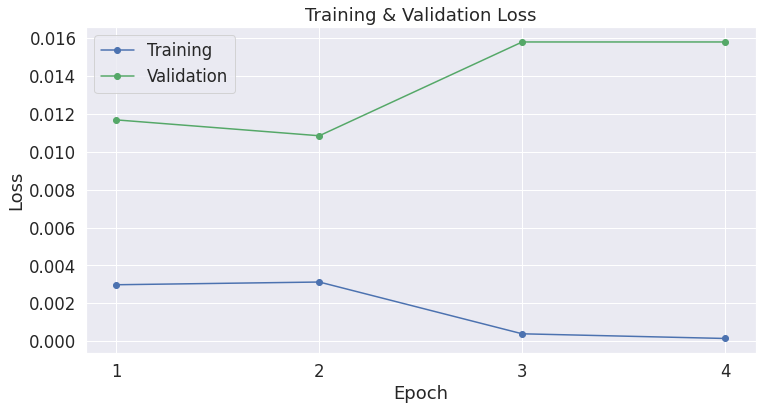

In [0]:
import matplotlib.pyplot as plt
% matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()